In [1]:
import os
import numpy as np
import torch
import PIL
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from torchvision.models.detection import KeypointRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch
import utils
import transforms as T
import matplotlib.pyplot as plt
import imageio
import random
from io import BytesIO
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import time

In [2]:
#ORIGAMI DATA LOADER

class OrigamiDataset(object):
    def __init__(self, csv_file1, csv_file2, transforms):   
        self.keypoints_frame = pd.read_csv(csv_file1) 
        self.box_frame = pd.read_csv(csv_file2)     
        self.transforms = transforms
        

    def __getitem__(self, idx):
        #LOAD IMAGES
        img_path = os.path.join("/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/DepthDataset/all/a", self.keypoints_frame.iloc[idx,0])
        img = Image.open(img_path).convert("RGB")
        num_objs=1    
        #BOX COORDINATES
        box = self.box_frame.iloc[idx,1:]
        box=np.asarray(box)
        box=box.astype('float')
        box=[box]
        #CONVERING TO TORCH.TENSOR
        boxes = torch.as_tensor(box, dtype=torch.float32)
        #ONLY ONE CLASS
        labels = torch.ones((num_objs,), dtype=torch.int64)
          
        #KEYPOINTS COORDINATES       
        x = self.keypoints_frame.iloc[idx,[1,3,5,7,9,11,13,15,17]]
        y = self.keypoints_frame.iloc[idx,[2,4,6,8,10,12,14,16,18]]
        x = np.asarray(x)
        x = x.astype('float')
        y = np.asarray(y)
        y = y.astype('float')
        
        z=[]
        for i,j in enumerate(x):

            m=[]            
            m.append(x[i])
            m.append(y[i])
            if ((5<x[i]<495) and (5<y[i]<495)):
                m.append(1)
            else:
                m.append(0)
            z.append(m)
        z=[z]               
        keypoints = torch.as_tensor(z, dtype=torch.float32)  
        
        #IMAGE ID
        image_id = torch.tensor([idx])
        
        #AREA
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #ALL INSTANCES ARE NOT CROWDED
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        #TARGET DICTIONARY                        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["keypoints"] = keypoints
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.keypoints_frame)

In [3]:
#MODEL

def get_model_instance_segmentation():
    
    #LOAD A PRE-TRAINED MODEL FOR CLASSIFICATION AND RETURN ONLY THE FEATURES
    backbone = torchvision.models.alexnet(pretrained=True).features
    # KeypointRCNN NEEDS TO KNOW THE NUMBER OF OUTPUT CHANNELS IN A BACKBONE.
    #FOR mobilenet_v2 IT'S 1280
    #FOR alexnet IT'S 256
    backbone.out_channels = 256

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be ['0']. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                              output_size=14,
                                                              sampling_ratio=2)
    # put the pieces together inside a KeypointRCNN model
    model = KeypointRCNN(backbone,
                         num_classes=2,
                         rpn_anchor_generator=anchor_generator,
                         box_roi_pool=roi_pooler,
                         keypoint_roi_pool=keypoint_roi_pooler,num_keypoints=9,box_detections_per_img=1)
    return model

In [4]:
#DATA LOADING AND TRAINING


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and robot
    # use our dataset and defined transformations
    dataset = OrigamiDataset('SimulationKP.csv', 'SimulationBOX.csv', transforms = T.Compose([T.ToTensor(),
                                               T.RandomHorizontalFlip(prob=0.4)]))
    dataset_sizes=len(dataset)
    print(dataset_sizes)
    dataset, dataset_test = torch.utils.data.random_split(dataset, [18000,2000])
    print(len(dataset))
    print(len(dataset_test))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=32, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation()
    #model=torchvision.models.detection.keypointrcnn_resnet50_fpn(num_keypoints=9)
    #Initialising with weights
    model.load_state_dict(torch.load('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/Weights/Second.pth'))

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 3

    for epoch in range(num_epochs):
        start = time.time()
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        #evaluate(model, data_loader_test, device=device)
        end = time.time()
        print('The time taken by {} epoch is {}'.format(end-start,epoch))
    
    print("That's it!")
    torch.save(model.state_dict(), '/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/Weights/Third.pth')
    print("okey")

In [5]:
#main()

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [7]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    img = img.resize((256, 256), Image.BICUBIC)
    return img

In [8]:
#Dataloader
#params['dataset']-->all-->1.a(RGB Image) and 2.b(Depth Image)

class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='all', direction='a2b'):
        super(DatasetFromFolder, self).__init__()
        self.direction = direction
        self.input_path = os.path.join(image_dir, subfolder)
        self.a_path = os.path.join(self.input_path, "a")
        self.b_path = os.path.join(self.input_path, "b")
        self.image_filenames = [x for x in os.listdir(self.a_path) if is_image_file(x)]

        transform_list = [transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

        self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        a = Image.open(os.path.join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(os.path.join(self.b_path, self.image_filenames[index])).convert('RGB')
        a = a.resize((542, 542), Image.BICUBIC)
        b = b.resize((542, 542), Image.BICUBIC)
        a = transforms.ToTensor()(a)
        b = transforms.ToTensor()(b)
        w_offset = random.randint(0, max(0, 542 - 512 - 1))
        h_offset = random.randint(0, max(0, 542 - 512 - 1))
    
        a = a[:, h_offset:h_offset + 512, w_offset:w_offset + 512]
        b = b[:, h_offset:h_offset + 512, w_offset:w_offset + 512]
    
        a = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(a)
        b = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(b)

        if random.random() < 0.5:
            idx = [i for i in range(a.size(2) - 1, -1, -1)]
            idx = torch.LongTensor(idx)
            a = a.index_select(2, idx)
            b = b.index_select(2, idx)

        if self.direction == "a2b":
            return a, b
        else:
            return b, a

    def __len__(self):
        return len(self.image_filenames)

In [9]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out

In [10]:
class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out

In [11]:
#GENERATOR512

class Generator512(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator512, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter, padding = 2, stride = 1, kernel_size=5)
        self.conv3 = ConvBlock(num_filter, num_filter * 2)
        self.conv4 = ConvBlock(num_filter*2, num_filter * 4)
        self.conv5 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv6 = ConvBlock(num_filter*8, num_filter*8, padding = 2, stride = 1, kernel_size=5)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 16)
        self.conv8 = ConvBlock(num_filter * 16, num_filter * 16)
        self.conv9 = ConvBlock(num_filter * 16, num_filter * 16)
        self.conv10 = ConvBlock(num_filter*16, num_filter*16, padding = 2, stride = 1, kernel_size=5)
        self.conv11 = ConvBlock(num_filter * 16, num_filter * 16)
        self.conv12 = ConvBlock(num_filter * 16, num_filter * 16, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 16, num_filter * 16, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 16 * 2, num_filter * 16, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 16 * 2, num_filter * 16, dropout=True, padding=2, stride=1, kernel_size=5)
        self.deconv4 = DeconvBlock(num_filter * 16 * 2, num_filter * 16, dropout=True)
        self.deconv5 = DeconvBlock(num_filter * 16 * 2, num_filter * 16)
        self.deconv6 = DeconvBlock(num_filter * 16 * 2, num_filter * 8)
        self.deconv7 = DeconvBlock(num_filter * 16, num_filter * 8, padding=2, stride=1, kernel_size=5)
        self.deconv8 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv9 = DeconvBlock(num_filter * 4 * 2, num_filter*2)
        self.deconv10 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv11 = DeconvBlock(num_filter * 2, num_filter , padding=2, stride=1, kernel_size=5)
        self.deconv12 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        enc9 = self.conv9(enc8)
        enc10 = self.conv10(enc9)
        enc11 = self.conv11(enc10)
        enc12 = self.conv12(enc11)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc12)
        dec1 = torch.cat([dec1, enc11], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc10], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc9], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc8], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc7], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc6], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc5], 1)
        dec8 = self.deconv8(dec7)
        dec8 = torch.cat([dec8, enc4], 1)
        dec9 = self.deconv9(dec8)
        dec9 = torch.cat([dec9, enc3], 1)
        dec10 = self.deconv10(dec9)
        dec10 = torch.cat([dec10, enc2], 1)
        dec11 = self.deconv11(dec10)
        dec11 = torch.cat([dec11, enc1], 1)
        dec12 = self.deconv12(dec11)
        out = torch.nn.Tanh()(dec12)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)

In [12]:
#DISCRIMINATOR512

class Discriminator512(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator512, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter*2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter*8, num_filter*8, padding = 2, stride = 1, kernel_size=5)
        self.conv6 = ConvBlock(num_filter*8, num_filter*8, padding = 2, stride = 1, kernel_size=5)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 16, stride=1)
        self.conv8 = ConvBlock(num_filter * 16, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)

In [13]:
# For logger
def to_np(x):
    return x.data.cpu().numpy()


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


# Plot losses
def plot_loss(d_losses, g_losses, num_epochs, save=False, save_dir='results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Loss_values_epoch_{:d}'.format(num_epochs) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


def plot_test_result(input, target, gen_image, epoch, training=True, save=False, save_dir='results/', show=False, fig_size=(5, 5)):
    if not training:
        fig_size = (input.size(2) * 3 / 100, input.size(3)/100)

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [input, gen_image, target]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        if training:
            save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        else:
            save_fn = save_dir + 'Test_result_{:d}'.format(epoch+1) + '.png'
            fig.subplots_adjust(bottom=0)
            fig.subplots_adjust(top=1)
            fig.subplots_adjust(right=1)
            fig.subplots_adjust(left=0)
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


# Make gif
def make_gif(dataset, num_epochs, save_dir='results/'):
    gen_image_plots = []
    for epoch in range(num_epochs):
        # plot for generating gif
        save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch + 1) + '.png'
        gen_image_plots.append(imageio.imread(save_fn))

    imageio.mimsave(save_dir + '_pix2pix_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)

In [14]:
#LOGGER

class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            # scipy.misc.toimage(img).save(s, format="png")
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [15]:
params = {}
params['dataset'] = '/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/DepthDataset'
params['direction'] = 'a2b'
params['batch_size'] = 1
params['ngf'] = 32
params['ndf'] = 32
params['input_size'] = 512
params['resize_scale'] = 542
params['crop_size'] = 512
params['fliplr'] = True
params['num_epochs'] = 2
params['lrG'] = 0.0002
params['lrD'] = 0.0002
params['lamb'] = 100
params['beta1'] = 0.5
params['beta2'] = 0.999

In [16]:
def train_test_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, val_idx)
    return datasets

In [21]:
# Directories for loading data and saving results
data_dir = params['dataset'] + '/'
save_dir = params['dataset'] + '_results/'
model_dir = params['dataset'] + '_model/'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Data pre-processing
transform = transforms.Compose([transforms.Scale(params['input_size']),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

dataset = DatasetFromFolder(data_dir, subfolder='all', direction=params['direction'])
print(len(dataset))
datasets = train_test_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['test']))

# Train data
train_data_loader = torch.utils.data.DataLoader(dataset=datasets['train'],
                                                batch_size=params['batch_size'],
                                                shuffle=True)

# Test data
test_data_loader = torch.utils.data.DataLoader(dataset=datasets['test'],
                                               batch_size=params['batch_size'],
                                               shuffle=False)
test_input, test_target = test_data_loader.__iter__().__next__()

# Models
G = Generator512(3, params['ngf'], 3)
D = Discriminator512(6, params['ndf'], 1)
G.cuda()
D.cuda()
G.normal_weight_init(mean=0.0, std=0.02)
D.normal_weight_init(mean=0.0, std=0.02)

# Set the logger
D_log_dir = save_dir + 'D_logs'
G_log_dir = save_dir + 'G_logs'
if not os.path.exists(D_log_dir):
    os.mkdir(D_log_dir)
D_logger = Logger(D_log_dir)

if not os.path.exists(G_log_dir):
    os.mkdir(G_log_dir)
G_logger = Logger(G_log_dir)

# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=params['lrG'], betas=(params['beta1'], params['beta2']))
D_optimizer = torch.optim.Adam(D.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))

# Training GAN
D_avg_losses = []
G_avg_losses = []

step = 0
for epoch in range(params['num_epochs']):
    D_losses = []
    G_losses = []

    # training
    for i, (input, target) in enumerate(train_data_loader):

        # input & target image data
        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = params['lamb'] * L1_loss(gen_image, y_)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, params['num_epochs'], i+1, len(train_data_loader), D_loss.item(), G_loss.item()))

        # ============ TensorBoard logging ============#
        D_logger.scalar_summary('losses', D_loss.item(), step + 1)
        G_logger.scalar_summary('losses', G_loss.item(), step + 1)
        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Show result for test image
    gen_image = G(Variable(test_input.cuda()))
    gen_image = gen_image.cpu().data
    plot_test_result(test_input, test_target, gen_image, epoch, save=True, save_dir=save_dir, show=True)

# Plot average losses
plot_loss(D_avg_losses, G_avg_losses, params['num_epochs'], save=True, save_dir=save_dir, show=True)

# Make gif
make_gif(params['dataset'], params['num_epochs'], save_dir=save_dir)

# Save trained parameters of model
torch.save(G.state_dict(), model_dir + 'generator_param.pkl')
torch.save(D.state_dict(), model_dir + 'discriminator_param.pkl')

20000
15000
5000


/home/richards/.local/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/richards/.local/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/richards/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Epoch [1/2], Step [1/15000], D_loss: 0.8501, G_loss: 52.6270
Epoch [1/2], Step [2/15000], D_loss: 1.0324, G_loss: 54.4859
Epoch [1/2], Step [3/15000], D_loss: 0.7884, G_loss: 40.5514
Epoch [1/2], Step [4/15000], D_loss: 0.6630, G_loss: 47.9198
Epoch [1/2], Step [5/15000], D_loss: 0.6312, G_loss: 41.7149
Epoch [1/2], Step [6/15000], D_loss: 0.6108, G_loss: 36.3218
Epoch [1/2], Step [7/15000], D_loss: 0.5728, G_loss: 41.7950
Epoch [1/2], Step [8/15000], D_loss: 0.5422, G_loss: 38.6524


KeyboardInterrupt: 

In [ ]:
def point_cloud(self, depth):
    """Transform a depth image into a point cloud with one point for each
    pixel in the image, using the camera transform for a camera
    centred at cx, cy with field of view fx, fy.

    depth is a 2-D ndarray with shape (rows, cols) containing
    depths from 1 to 254 inclusive. The result is a 3-D array with
    shape (rows, cols, 3). Pixels with invalid depth in the input have
    NaN for the z-coordinate in the result.

    """
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    valid = (depth > 0) & (depth < 255)
    z = np.where(valid, depth / 256.0, np.nan)
    x = np.where(valid, z * (c - self.cx) / self.fx, 0)
    y = np.where(valid, z * (r - self.cy) / self.fy, 0)
    return np.dstack((x, y, z))

In [ ]:
data_dir = params['dataset'] + '/'
model_dir = params['dataset'] + '_model/'
# Data pre-processing
transform = transforms.Compose([transforms.Scale(params['input_size']),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

dataset = DatasetFromFolder(data_dir, subfolder='all', direction=params['direction'])
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                batch_size=params['batch_size'],
                                                shuffle=True)
G = Generator(3, params['ngf'], 3)
G.cuda()
G.load_state_dict(torch.load('/home/richards/Richards/ML/NUSIntern/vision-master/references/detection/Depth Maping/DepthData2_model/generator_param.pkl'))
epoch=0
for i in range(4):
    test_input, test_target = data_loader.__iter__().__next__()
    gen_image = G(Variable(test_input.cuda()))
    gen_image = gen_image.cpu().data
    plot_test_result(test_input, test_target, gen_image, epoch, save=False, show=True)

In [21]:
#CHECKING THE OUTPUT WITH DATASET WITH DATA TRANSFORM
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import matplotlib.patches as patches
import utils
import time
import transforms as T

model = get_model_instance_segmentation()
model.load_state_dict(torch.load('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/Weights/mask rcnn/Fourth.pth'))

G = Generator512(3, params['ngf'], 3)
G.load_state_dict(torch.load('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/Weights/6generator_param.pkl'))

dataset = OrigamiDataset('SimulationKP.csv', 'SimulationBOX.csv', transforms = T.Compose([T.ToTensor(),
                                               T.RandomHorizontalFlip(prob=0.4),T.Rescale()]))
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)
i=-1
for image,target in dataset:
    i+=1
    if i>1000:
        if i%2000==0:
            tic=time.time()
            #print(image.shape)
            gen_image = torch.unsqueeze(image,0)
            #print(gen_image.shape)
            gen_image = G(Variable(gen_image))
            gen_image = gen_image.cpu().data
            print(gen_image[0].shape)
            gen_image = (((gen_image[0] - gen_image[0].min()) * 255) / (gen_image[0].max() - gen_image[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
            print(gen_image.shape)
            gen_image = np.mean(gen_image, axis=2)
            #print(gen_image.shape)
            plt.figure(figsize=(9,15))
            plt.imshow(gen_image,cmap='gray')
            plt.show()
            #print('GT Value:')    
            gtk = target['keypoints']
            boxxg = target['boxes'][0]
            boxxg = boxxg.detach().numpy()
            #print(boxxg)
            #print(boxxg[0])
            #print(gtk)
            img=image

            img = img.permute(1,2,0) 
            img=np.array(img)
            
            image=[image]
            model.eval()
            output = model(image)
            dtk = output[0]['keypoints']
            threeD = np.ones((9,3),dtype=int)
            dtk=dtk.detach().numpy()
            threeD[:,0:2] = dtk[0,:,0:2]
            threeD[:,2] = gen_image[threeD[:,0],threeD[:,1]]
            #print('dtk:{}'.format(dtk))
            #print('threeD:{}'.format(threeD))
            threeD[:,0] = (threeD[:,0]-256)*((threeD[:,2]*0.04831)/25)
            threeD[:,1] = (threeD[:,1]-256)*((threeD[:,2]*0.04831)/25)
            #print('threeD coordinates:{}'.format(threeD))
            if dtk.shape[0]!=0:                
                boxxd = output[0]['boxes']
                boxxd = boxxd.detach().numpy()
                #print(boxxd)
                boxxd = boxxd[0]
                #print('DT Value:{}'.format(dtk))
                dtk=dtk[0]
                gtk=gtk.detach().numpy()
                gtk=gtk[0]
                plt.figure(figsize=(9,15))
                plt.imshow(img)
                ax = plt.gca()
                #print(gtk[:,0],gtk[:,1])
                plt.plot(dtk[:,0],dtk[:,1],marker = 'o', c='r')
                plt.scatter(dtk[:, 0], dtk[:, 1], s=200, marker='.', c='r')
                rect = patches.Rectangle((boxxd[0],boxxd[1]),boxxd[2]-boxxd[0],boxxd[3]-boxxd[1],linewidth=2,edgecolor='g',facecolor='g',alpha=0.13)
                ax.add_patch(rect)
                plt.savefig('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/image'+str(i)+'.jpg')
                plt.show()
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.scatter3D(threeD[:,0], threeD[:,1], threeD[:,2], marker='o', color='green')
                ax.plot3D(threeD[:,0], threeD[:,1], threeD[:,2])
                plt.savefig('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/3Dimage'+str(i)+'.jpg')
                plt.show()
            toc=time.time()
            print('time:{}'.format(tic-toc))

torch.Size([3, 512, 512])
(512, 512, 3)
{'boxes': tensor([[ 72., 168., 244., 395.]]), 'labels': tensor([1]), 'keypoints': tensor([[[218., 194.,   1.],
         [203., 213.,   1.],
         [189., 229.,   1.],
         [173., 249.,   1.],
         [161., 259.,   1.],
         [141., 273.,   1.],
         [121., 296.,   1.],
         [105., 335.,   1.],
         [112., 371.,   1.]]]), 'image_id': tensor([2000]), 'area': tensor([39044.]), 'iscrowd': tensor([0])}


AttributeError: 'dict' object has no attribute 'permute'

In [ ]:
#CHECKING THE OUTPUT WITH DATASET WITH DATA TRANSFORM

import matplotlib.pyplot as plt 
import cv2
import matplotlib.patches as patches
import utils
import time
import transforms as T

model = get_model_instance_segmentation()
model.load_state_dict(torch.load('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/Weights/Third.pth'))

dataset = OrigamiDataset('SimulationKP.csv', 'SimulationBOX.csv', transforms = T.Compose([T.ToTensor(),
                                               T.RandomHorizontalFlip(prob=0.4)]))
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)
i=-1
for image,target in dataset:
    i+=1
    if i>1000:
        if i%500==0:
            tic=time.time()
            #image = image[0]
            #target = target[0]
            print('GT Value:')    
            gtk = target['keypoints']
            boxxg = target['boxes'][0]
            boxxg = boxxg.detach().numpy()
            print(boxxg)
            print(boxxg[0])
            print(gtk)
            img=image
            #image=np.array(image)
            img = img.permute(1,2,0) 
            img=np.array(img)
            #image=image/255
            #image=torch.from_numpy(image)
            #image=image.type(torch.float32)
            image=[image]
            model.eval()
            output = model(image)
            dtk = output[0]['keypoints']
            if dtk.shape[0]!=0:                
                boxxd = output[0]['boxes']
                boxxd = boxxd.detach().numpy()
                #print(boxxd)
                boxxd = boxxd[0]
                print('DT Value:{}'.format(dtk))
                dtk=dtk.detach().numpy()
                dtk=dtk[0]
                gtk=gtk.detach().numpy()
                gtk=gtk[0]
                plt.figure(figsize=(15,25))
                plt.imshow(img)
                ax = plt.gca()
                print(gtk[:,0],gtk[:,1])
                plt.plot(dtk[:,0],dtk[:,1],marker = 'o', c='r')
                plt.scatter(dtk[:, 0], dtk[:, 1], s=200, marker='.', c='r')
                rect = patches.Rectangle((boxxd[0],boxxd[1]),boxxd[2]-boxxd[0],boxxd[3]-boxxd[1],linewidth=2,edgecolor='g',facecolor='g',alpha=0.13)
                ax.add_patch(rect)
                plt.show()
            toc=time.time()
            print('time:{}'.format(tic-toc))

(500, 500)


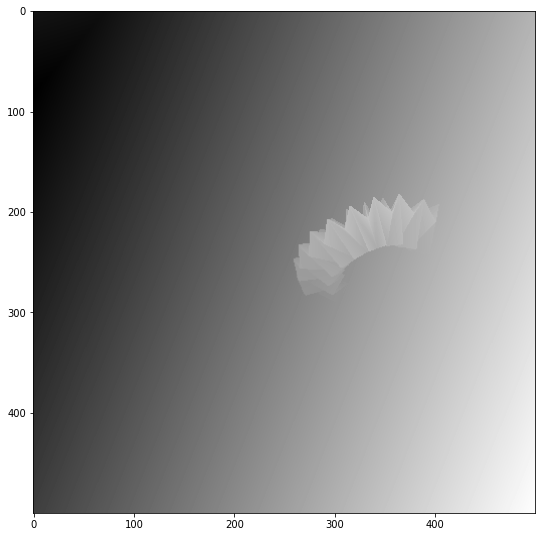

/home/richards/.local/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


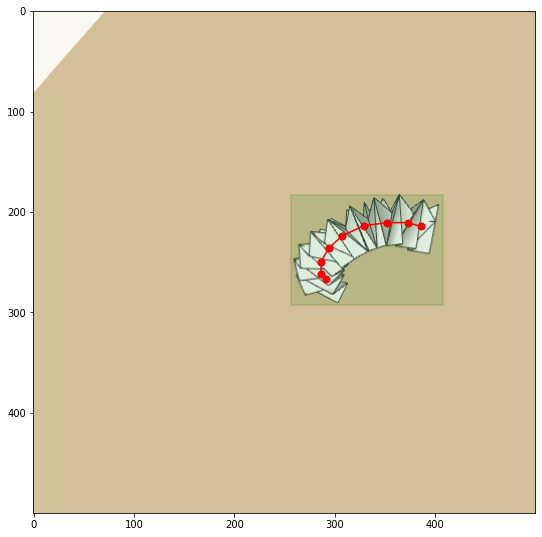

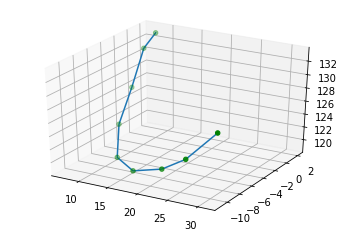

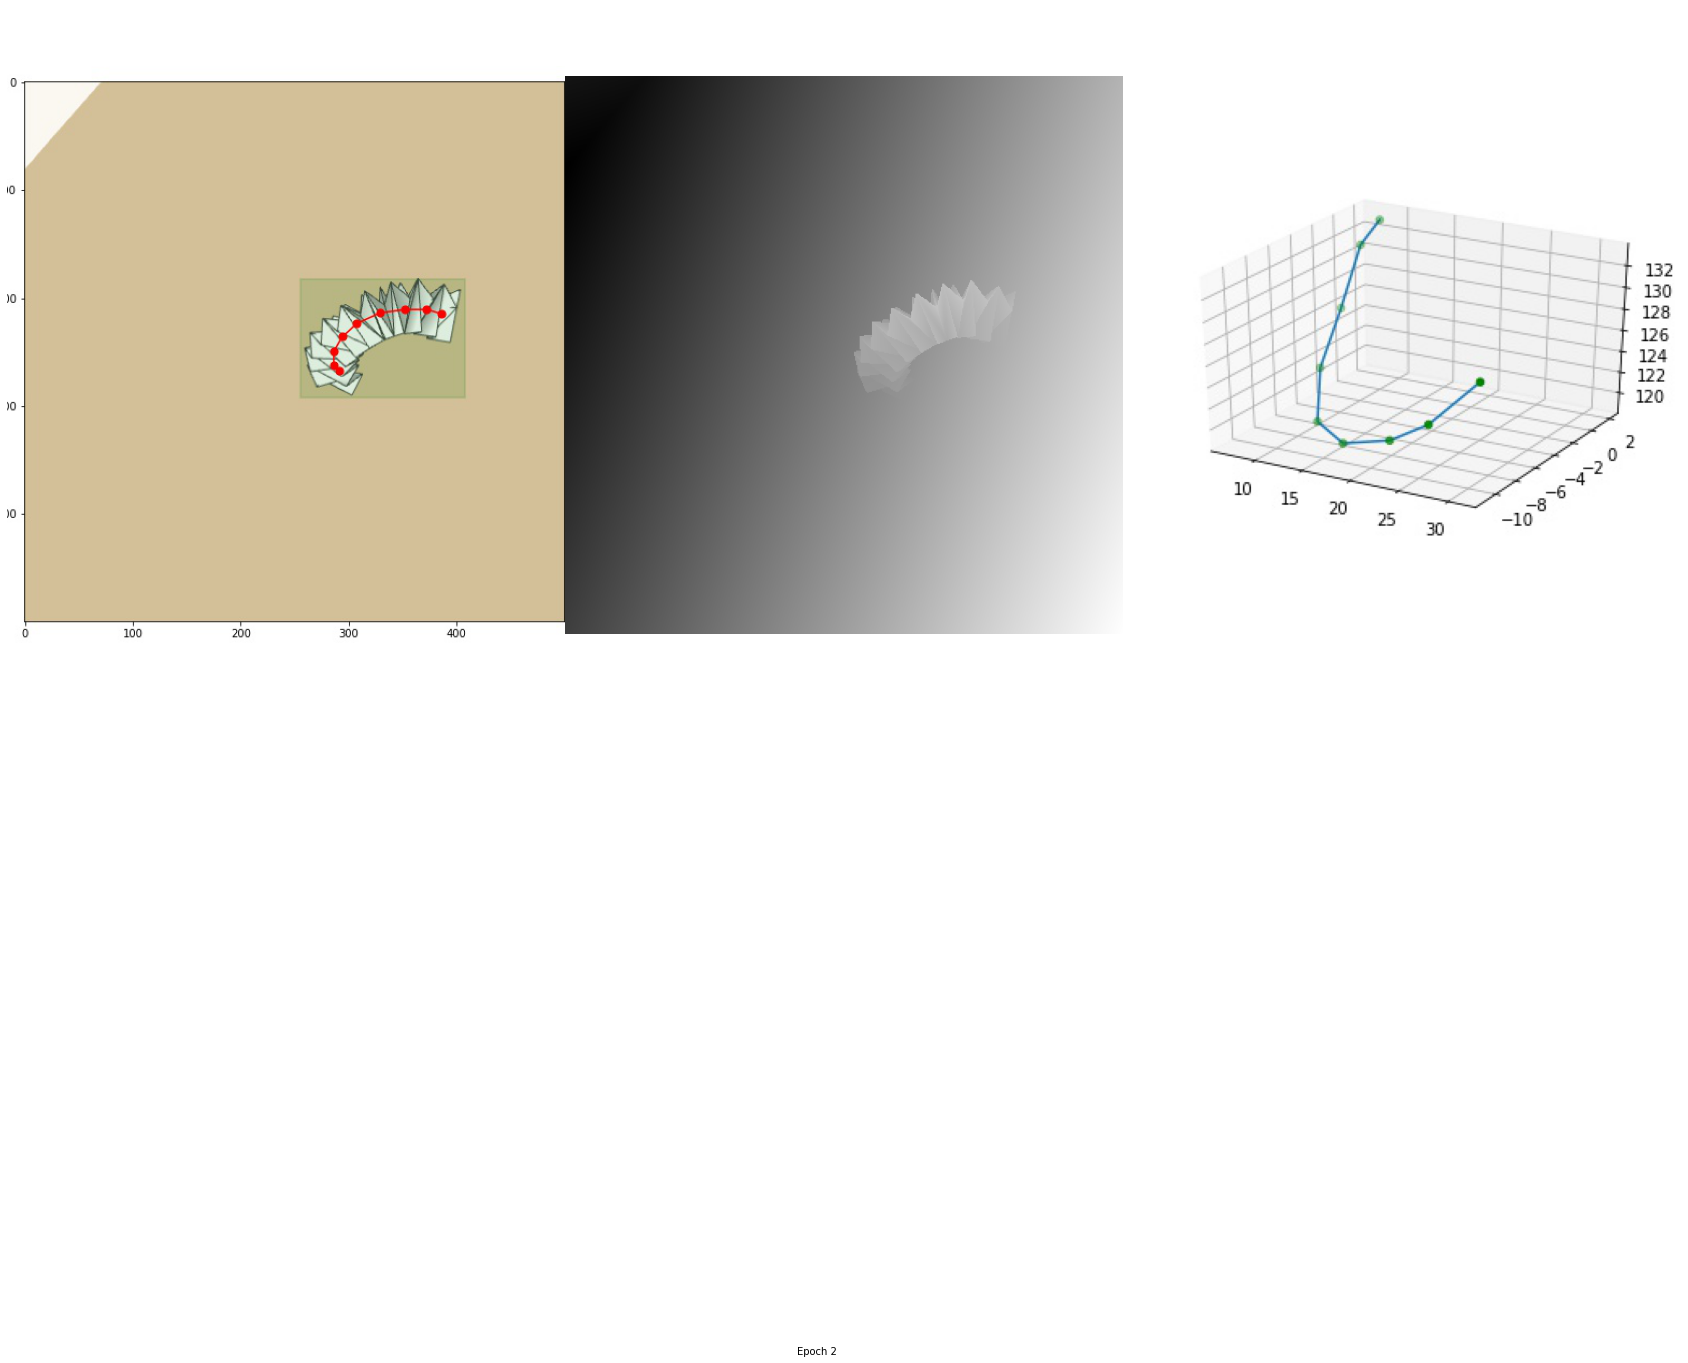

In [38]:
#CHECKING THE OUTPUT WITH DATASET WITH DATA TRANSFORM
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import matplotlib.patches as patches
import utils
import time
import transforms as T
import math

def plot_test_result(input, target, gen_image, epoch=1, training=True, save=True, save_dir='/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/Images/', show=True, fig_size=(30, 30)):
    if not training:
        fig_size = (input.size(2) * 3 , input.size(3))

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [input, gen_image, target]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        if training:
            save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        else:
            save_fn = save_dir + 'Test_result_{:d}'.format(epoch+1) + '.png'
            fig.subplots_adjust(bottom=0)
            fig.subplots_adjust(top=1)
            fig.subplots_adjust(right=1)
            fig.subplots_adjust(left=0)
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


model = get_model_instance_segmentation()
model.load_state_dict(torch.load('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/Weights/mask rcnn/Fourth.pth'))

G = Generator512(3, params['ngf'], 3)
G.load_state_dict(torch.load('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/Weights/6generator_param.pkl'))

dataset = OrigamiDataset('SimulationKP.csv', 'SimulationBOX.csv', transforms = T.Compose([T.ToTensor(),
                                               T.RandomHorizontalFlip(prob=0.4),T.Rescale()]))
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

image = Image.open("/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/DepthDataset/all/a/img_omega_244.png").convert('RGB')
gen_image = Image.open("/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/DepthDataset/all/b/img_omega_244.png").convert("L")
gen = np.array(gen_image)
print(gen.shape)
plt.figure(figsize=(9,15))
plt.imshow(gen,cmap='gray')
plt.show()
img=np.array(image)
image = transforms.ToTensor()(image)
image = [image]



model.eval()

output = model(image)

dtk = output[0]['keypoints']
threeD = np.ones((9,3),dtype=int)
dtk=dtk.detach().numpy()
threeD[:,0:2] = dtk[0,:,0:2]
threeD[:,2] = gen[threeD[:,0],threeD[:,1]]
threeD[:,0] = (threeD[:,0]-256)*((threeD[:,2]*0.04831)/25)
threeD[:,1] = (threeD[:,1]-256)*((threeD[:,2]*0.04831)/25)

if dtk.shape[0]!=0:                
    boxxd = output[0]['boxes']
    boxxd = boxxd.detach().numpy()
    boxxd = boxxd[0]
    dtk=dtk[0]
    plt.figure(figsize=(9,15))
    plt.imshow(img)
    ax = plt.gca()
    plt.plot(dtk[:,0],dtk[:,1],marker = 'o', c='r')
    plt.scatter(dtk[:, 0], dtk[:, 1], s=200, marker='.', c='r')
    rect = patches.Rectangle((boxxd[0],boxxd[1]),boxxd[2]-boxxd[0],boxxd[3]-boxxd[1],linewidth=2,edgecolor='g',facecolor='g',alpha=0.13)
    ax.add_patch(rect)
    plt.savefig('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/Images/image.jpg')
    plt.show()
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(threeD[:,0], threeD[:,1], threeD[:,2], marker='o', color='green')
    ax.plot3D(threeD[:,0], threeD[:,1], threeD[:,2])
    plt.savefig('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/Images/3Dimage.jpg')
    plt.show()
    image = Image.open('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/Images/image.jpg').convert("RGB")
    w,h = image.size
    image = np.array(image)
    image = image[math.ceil(0.2*h):math.ceil(0.8*h),math.ceil(0.1*w):math.ceil(0.9*w),:]
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    image = [image]
    gen_image = Image.open("/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/references/detection/DepthDataset/all/b/img_omega_244.png").convert("RGB")
    gen_image = transforms.ToTensor()(gen_image)
    gen_image = [gen_image]
    Dplot = Image.open('/home/richards/Richards/ML/NUSIntern/ORIGAMI AcRec/Images/3Dimage.jpg').convert('RGB')
    w,h = Dplot.size
    Dplot = np.array(Dplot)
    Dplot = Dplot[math.ceil(0.1*h):math.ceil(0.9*h),math.ceil(0.1*w):math.ceil(0.9*w),:]
    Dplot = Image.fromarray(Dplot)
    Dplot = transforms.ToTensor()(Dplot)
    Dplot = [Dplot]
    plot_test_result(image,Dplot,gen_image)